## 08-6. 토픽 모델링 - 20 뉴스그룹

In [1]:
#fetch_20newsgroups()로 인터넷에서 로컬로 데이터 내려받기
from sklearn.datasets import fetch_20newsgroups
#로컬 데이터 경로
data_home="/Users/bluecloud/Documents/대학/유런/데이터셋/20news-bydate-test"

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 모토사이클, 야구, 그래픽스, 윈도우즈, 중동, 기독교, 의학, 우주 주제를 추출
cats = ['rec.motorcycles', 'rec.sport.baseball', 'comp.graphics', 'comp.windows.x','talk.politics.mideast', 'soc.religion.christian', 'sci.electronics', 'sci.med']

# 위에서 cats 변수로 기재된 카터고리만 추출 >> categories에 cats 입력
news_df=fetch_20newsgroups(data_home=data_home,subset='all',remove=('headers','footers','quotes'),categories=cats,random_state=0)

# LDA는 Count기반의 벡터화만 적용
count_vect=CountVectorizer(max_df=0.95,max_features=1000,min_df=2,stop_words='english',ngram_range=(1,2))
feat_vect=count_vect.fit_transform(news_df.data)
print('CountVectorizer Shape :',feat_vect.shape)

CountVectorizer Shape : (7862, 1000)


In [5]:
lda=LatentDirichletAllocation(n_components=8,random_state=0)
lda.fit(feat_vect)
print(lda.components_.shape)
lda.components_

(8, 1000)


array([[3.60992018e+01, 1.35626798e+02, 2.15751867e+01, ...,
        3.02911688e+01, 8.66830093e+01, 6.79285199e+01],
       [1.25199920e-01, 1.44401815e+01, 1.25045596e-01, ...,
        1.81506995e+02, 1.25097844e-01, 9.39593286e+01],
       [3.34762663e+02, 1.25176265e-01, 1.46743299e+02, ...,
        1.25105772e-01, 3.63689741e+01, 1.25025218e-01],
       ...,
       [3.60204965e+01, 2.08640688e+01, 4.29606813e+00, ...,
        1.45056650e+01, 8.33854413e+00, 1.55690009e+01],
       [1.25128711e-01, 1.25247756e-01, 1.25005143e-01, ...,
        9.17278769e+01, 1.25177668e-01, 3.74575887e+01],
       [5.49258690e+01, 4.47009532e+00, 9.88524814e+00, ...,
        4.87048440e+01, 1.25034678e-01, 1.25074632e-01]])

In [11]:
def display_topics(model,feature_names,no_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('Topic #',topic_index)
        # components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array index를 반환
        topic_word_indexes=topic.argsort()[::-1]
        topic_indexes=topic_word_indexes[:no_top_words]
        # top_indexes대상인 index별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat=' '.join([feature_names[i] for i in topic_indexes])
        print(feature_concat)
        
# CountVectorizer객체 내의 전체 word들의 명칭을 get_features_names( )를 통해 추출
# 최신 Scikit-learn에서는 get_feature_names가 get_feature_names_out으로 대체됨…
feature_names=count_vect.get_feature_names_out()

# 토픽별 가장 연관도가 높은 word 15개만 추출
display_topics(lda,feature_names,15)

Topic # 0
year 10 game medical health team 12 20 disease cancer 1993 games years patients good
Topic # 1
don just like know people said think time ve didn right going say ll way
Topic # 2
image file jpeg program gif images output format files color entry 00 use bit 03
Topic # 3
like know don think use does just good time book read information people used post
Topic # 4
armenian israel armenians jews turkish people israeli jewish government war dos dos turkey arab armenia 000
Topic # 5
edu com available graphics ftp data pub motif mail widget software mit information version sun
Topic # 6
god people jesus church believe christ does christian say think christians bible faith sin life
Topic # 7
use dos thanks windows using window does display help like problem server need know run


## 08-7. 문서 군집화 소개와 실습

In [17]:
import pandas as pd
import glob,os

# 디렉터리 재설정
path=r'/Users/bluecloud/Documents/대학/유런/데이터셋/topics'
#path로 지정한 dir 밑에 있는 모든 .data 파일의 파일명을 리스트업
all_files=glob.glob(os.path.join(path,"*.data"))
filename_list=[]
opinion_text=[]

# 개별 파일의 파일명은 filename_list로 취합
# 개별 파일의 파일 내용은 DataFrame 로딩 후 다시 string 으로 변환해 opinion_text list로 취합
for file_ in all_files:
    # 개별 파일 읽어서 df생성
    df=pd.read_table(file_,index_col=None,header=0,encoding='latin1')
    # 절대 경로에서 파일명 추출
    filename_ = os.path.splitext(os.path.basename(file_))[0]
    filename=filename_.split('.')[0]
    # 파일명 list와 파일 내용 1ist에 파일명과 파일 내용을 추가
    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})
document_df.head()

,filename,opinion_text
0,battery-life_ipod_nano_8gb,...
1,gas_mileage_toyota_camry_2007,...
2,room_holiday_inn_london,...
3,location_holiday_inn_london,...
4,staff_bestwestern_hotel_sfo,...


In [27]:
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

# 입력으로 들어온 token단어들에 대해서 lemmatization 어근 변환
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# TfidfVectorizer 객체 생성 시 tokenizer인자로 해당 함수를 설정하여 lemmatization 적용
# 입력으로 문장을 받아서 stop words 제거-> 소문자 변환 -> 단어 토큰화 -> lemmatization 어근 변환 
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))


tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english',ngram_range=(1,2), min_df=0.05, max_df=0.85 )

#opinion_text 컬럼값으로 feature vectorization 수행
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])                   

[nltk_data] Downloading package punkt to /Users/bluecloud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bluecloud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [29]:
from sklearn.cluster import KMeans

#5개 집합으로 군집화 수행
km_cluster=KMeans(n_clusters=5,max_iter=10000,random_state=0)
km_cluster.fit(feature_vect)
cluster_label=km_cluster.labels_
cluster_centers=km_cluster.cluster_centers_

In [31]:
document_df['cluster_label']=cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,battery-life_ipod_nano_8gb,...,1
1,gas_mileage_toyota_camry_2007,...,4
2,room_holiday_inn_london,...,3
3,location_holiday_inn_london,...,0
4,staff_bestwestern_hotel_sfo,...,3


In [33]:
document_df[document_df['cluster_label']==0].sort_values(by='filename')

,filename,opinion_text,cluster_label
17,food_holiday_inn_london,...,0
32,food_swissotel_chicago,...,0
3,location_holiday_inn_london,...,0
41,price_amazon_kindle,...,0
28,price_holiday_inn_london,...,0
16,service_bestwestern_hotel_sfo,...,0
27,service_holiday_inn_london,...,0
13,service_swissotel_hotel_chicago,...,0


In [35]:
document_df[document_df['cluster_label']==1].sort_values(by='filename')

,filename,opinion_text,cluster_label
33,accuracy_garmin_nuvi_255W_gps,...,1
9,battery-life_amazon_kindle,...,1
0,battery-life_ipod_nano_8gb,...,1
11,battery-life_netbook_1005ha,...,1
26,buttons_amazon_kindle,...,1
34,directions_garmin_nuvi_255W_gps,...,1
48,display_garmin_nuvi_255W_gps,...,1
36,eyesight-issues_amazon_kindle,...,1
21,features_windows7,...,1
44,fonts_amazon_kindle,...,1


In [37]:
document_df[document_df['cluster_label']==2].sort_values(by='filename')

,filename,opinion_text,cluster_label
45,interior_honda_accord_2008,...,2
22,interior_toyota_camry_2007,...,2
42,quality_toyota_camry_2007,...,2


In [39]:
document_df[document_df['cluster_label']==3].sort_values(by='filename')

,filename,opinion_text,cluster_label
31,bathroom_bestwestern_hotel_sfo,...,3
49,free_bestwestern_hotel_sfo,...,3
39,location_bestwestern_hotel_sfo,...,3
50,parking_bestwestern_hotel_sfo,...,3
2,room_holiday_inn_london,...,3
46,rooms_bestwestern_hotel_sfo,...,3
30,rooms_swissotel_chicago,...,3
4,staff_bestwestern_hotel_sfo,...,3
20,staff_swissotel_chicago,...,3


In [41]:
document_df[document_df['cluster_label']==4].sort_values(by='filename')

,filename,opinion_text,cluster_label
18,comfort_honda_accord_2008,...,4
43,comfort_toyota_camry_2007,...,4
1,gas_mileage_toyota_camry_2007,...,4
35,mileage_honda_accord_2008,...,4
47,performance_honda_accord_2008,...,4
29,seats_honda_accord_2008,...,4
23,transmission_toyota_camry_2007,...,4


In [43]:
from sklearn.cluster import KMeans

# 3개의 집합으로 군집화
km_cluster=KMeans(n_clusters=3,max_iter=10000,random_state=0)
km_cluster.fit(feature_vect)
cluster_label=km_cluster.labels_
cluster_centers=km_cluster.cluster_centers_

# 소속 군집을 cluster_label 칼럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label']=cluster_label
document_df.sort_values(by='cluster_label')

,filename,opinion_text,cluster_label
50,parking_bestwestern_hotel_sfo,...,0
27,service_holiday_inn_london,...,0
28,price_holiday_inn_london,...,0
30,rooms_swissotel_chicago,...,0
20,staff_swissotel_chicago,...,0
31,bathroom_bestwestern_hotel_sfo,...,0
32,food_swissotel_chicago,...,0
17,food_holiday_inn_london,...,0
16,service_bestwestern_hotel_sfo,...,0
13,service_swissotel_hotel_chicago,...,0


In [45]:
cluster_centers=km_cluster.cluster_centers_
print('cluster_centers shape :', cluster_centers.shape)
print(cluster_centers)

cluster_centers shape : (3, 4611)
[[0.         0.00099499 0.00174637 ... 0.         0.00183397 0.00144581]
 [0.01005322 0.         0.         ... 0.00706287 0.         0.        ]
 [0.         0.00092551 0.         ... 0.         0.         0.        ]]


In [47]:
# 군집별 top n 핵심 단어, 그 단어의 중심 위치 상대값, 대상 파일명들을 반환 
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
    cluster_details = {}
    
    # cluster_centers array 의 값이 큰 순으로 정렬된 index 값을 반환
    # 군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함.  
    centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    #개별 군집별로 iteration하면서 핵심단어, 그 단어의 중심 위치 상대값, 대상 파일명 입력
    for cluster_num in range(clusters_num):
        # 개별 군집별 정보를 담을 데이터 초기화. 
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # cluster_centers_.argsort()[:,::-1] 로 구한 index 를 이용하여 top n 피처 단어를 구함. 
        top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features = [ feature_names[ind] for ind in top_feature_indexes ]
        
        # top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함 
        top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()
        
        # cluster_details 딕셔너리 객체에 개별 군집별 핵심 단어와 중심위치 상대값, 그리고 해당 파일명 입력
        cluster_details[cluster_num]['top_features'] = top_features
        cluster_details[cluster_num]['top_features_value'] = top_feature_values
        filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['filename']
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['filenames'] = filenames
        
    return cluster_details

In [49]:
def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print('####### Cluster {0}'.format(cluster_num))
        print('Top features:', cluster_detail['top_features'])
        print('Reviews 파일명 :',cluster_detail['filenames'][:7])
        print('==================================================')

In [51]:
feature_names=tfidf_vect.get_feature_names_out()
cluster_details=get_cluster_details(cluster_model=km_cluster,cluster_data=document_df,feature_names=feature_names, clusters_num=3,top_n_features=10)
print_cluster_details(cluster_details)

####### Cluster 0
Top features: ['room', 'hotel', 'service', 'staff', 'food', 'location', 'bathroom', 'clean', 'price', 'parking']
Reviews 파일명 : ['room_holiday_inn_london', 'location_holiday_inn_london', 'staff_bestwestern_hotel_sfo', 'service_swissotel_hotel_chicago', 'service_bestwestern_hotel_sfo', 'food_holiday_inn_london', 'staff_swissotel_chicago']
####### Cluster 1
Top features: ['screen', 'battery', 'keyboard', 'battery life', 'life', 'kindle', 'direction', 'video', 'size', 'voice']
Reviews 파일명 : ['battery-life_ipod_nano_8gb', 'voice_garmin_nuvi_255W_gps', 'speed_garmin_nuvi_255W_gps', 'size_asus_netbook_1005ha', 'screen_garmin_nuvi_255W_gps', 'battery-life_amazon_kindle', 'satellite_garmin_nuvi_255W_gps']
####### Cluster 2
Top features: ['interior', 'seat', 'mileage', 'comfortable', 'gas', 'gas mileage', 'transmission', 'car', 'performance', 'quality']
Reviews 파일명 : ['gas_mileage_toyota_camry_2007', 'comfort_honda_accord_2008', 'interior_toyota_camry_2007', 'transmission_toyot

## 08-8. 문서 유사도

In [53]:
import numpy as np
# 두 벡터의 코사인 유사도
def cos_similarity(v1, v2):
    dot_product = v1 @ v2
    ab_norm = np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2)))
    similarity = dot_product / ab_norm
    
    return similarity

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends' ,
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)


(3, 18)


In [59]:
# TFidfVectorizer로 transform()한 결과는 Sparse Matrix이므로 Dense Matrix로 변환
feature_vect_dense=feature_vect_simple.todense()

# 첫 번째 문장과 두 번째 문장의 피처 벡터 추출
vect1=np.array(feature_vect_dense[0]).reshape(-1,)
vect2=np.array(feature_vect_dense[1]).reshape(-1,)

# 코사인 유사도 추출
similarity_simple=cos_similarity(vect1,vect2)
print('문장 1, 문장 2 코사인 유사도 : {0:.3f}'.format(similarity_simple))

문장 1, 문장 2 코사인 유사도 : 0.402


In [61]:
# 첫 번째 문장과 세 번째 문장의 피처 벡터 추출
vect1=np.array(feature_vect_dense[0]).reshape(-1,)
vect3=np.array(feature_vect_dense[2]).reshape(-1,)

# 코사인 유사도 추출
similarity_simple=cos_similarity(vect1,vect3)
print('문장 1, 문장 3 코사인 유사도 : {0:.3f}'.format(similarity_simple))

# 두 번째 문장과 세 번째 문장의 피처 벡터 추출
vect2=np.array(feature_vect_dense[1]).reshape(-1,)
vect3=np.array(feature_vect_dense[2]).reshape(-1,)

# 코사인 유사도 추출
similarity_simple=cos_similarity(vect2,vect3)
print('문장 2, 문장 3 코사인 유사도 : {0:.3f}'.format(similarity_simple))

문장 1, 문장 3 코사인 유사도 : 0.404
문장 2, 문장 3 코사인 유사도 : 0.456


In [63]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair=cosine_similarity(feature_vect_simple[0],feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


In [67]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0] , feature_vect_simple[1:])
print(similarity_simple_pair)

[[0.40207758 0.40425045]]


In [69]:
similarity_simple_pair = cosine_similarity(feature_vect_simple , feature_vect_simple)
print(similarity_simple_pair)
print('shape:',similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


In [71]:
import pandas as pd
import glob,os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# 디렉터리 재설정
path=r'/Users/bluecloud/Documents/대학/유런/데이터셋/topics'
#path로 지정한 dir 밑에 있는 모든 .data 파일의 파일명을 리스트업
all_files=glob.glob(os.path.join(path,"*.data"))
filename_list=[]
opinion_text=[]

# 개별 파일의 파일명은 filename_list로 취합
# 개별 파일의 파일 내용은 DataFrame 로딩 후 다시 string 으로 변환해 opinion_text list로 취합
for file_ in all_files:
    # 개별 파일 읽어서 df생성
    df=pd.read_table(file_,index_col=None,header=0,encoding='latin1')
    # 절대 경로에서 파일명 추출
    filename_ = os.path.splitext(os.path.basename(file_))[0]
    filename=filename_.split('.')[0]
    # 파일명 list와 파일 내용 1ist에 파일명과 파일 내용을 추가
    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})
tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english',ngram_range=(1,2), min_df=0.05, max_df=0.85 )
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text']) 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [73]:
# 3개의 집합으로 군집화
km_cluster=KMeans(n_clusters=3,max_iter=10000,random_state=0)
km_cluster.fit(feature_vect)
cluster_label=km_cluster.labels_
cluster_centers=km_cluster.cluster_centers_
document_df['cluster_label']=cluster_label

In [75]:
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=0이 호텔 군집화 데이터임, 인덱스 추출
hotel_indexes=document_df[document_df['cluster_label']==0].index
print('호텔로 군집화 된 문서들의 DataFrame Index : ', hotel_indexes)

# 호텔로 군집화된 데이터 중 첫 번째 문서를 추출해 파일명 표시
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('##### 비교 기준 문서명', comparison_docname, '와 타 문서 유사도 #####')

'''
document_df에서 추출한 Index 객체를 feature_vect로 입력해 호텔 군집화된 feature_vect 추출
이를 이용해 호텔로 군집화된 문서 중 첫 번째 문서와 다른 문서간의 코사인 유사도 측정
'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 군집화 된 문서들의 DataFrame Index :  Index([2, 3, 4, 13, 16, 17, 20, 27, 28, 30, 31, 32, 39, 46, 49, 50], dtype='int64')
##### 비교 기준 문서명 room_holiday_inn_london 와 타 문서 유사도 #####
[[1.         0.19917258 0.22235374 0.37631406 0.26026786 0.15836737
  0.19544761 0.40020673 0.31124876 0.77312013 0.51442299 0.15026112
  0.16717527 0.81484367 0.11154184 0.10831277]]


Text(0.5, 1.0, 'room_holiday_inn_london')

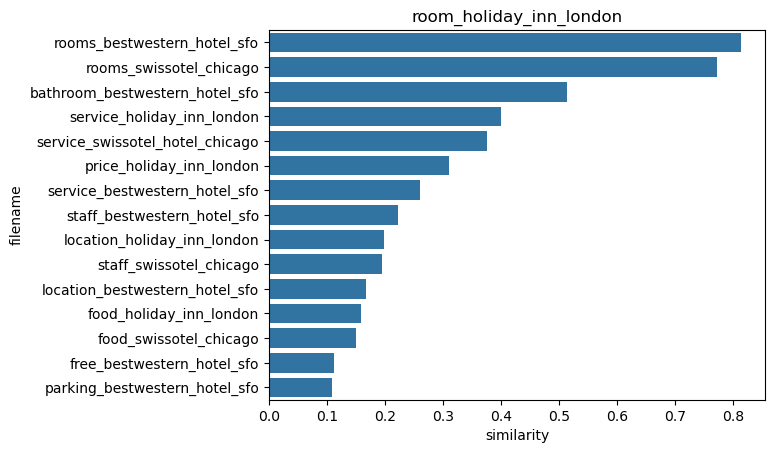

In [77]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 첫 번째 문서와 타 문서 간 유사도가 큰 순으로 정렬한 인덱스를 추출하되 자기 자신은 제외
sorted_index = similarity_pair.argsort()[:, ::-1]
sorted_index = sorted_index[:, 1:]

# 유사도가 큰 순으로 hotel_indexes를 추출해 재정렬
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 인덱스와 유사도 값을 이용해 파일명과 유사도 값을 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

sns.barplot(x = 'similarity', y = 'filename', data = hotel_1_sim_df)
plt.title(comparison_docname)

In [79]:
from konlpy.tag import Okt
tw_tag = Okt()

In [81]:
import pandas as pd
train_df=pd.read_csv('/Users/bluecloud/Documents/대학/유런/데이터셋/navermovie/ratings_train.txt',sep='\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [83]:
train_df['label'].value_counts()

label
0    75173
1    74827
Name: count, dtype: int64

In [85]:
import re

train_df = train_df.fillna(' ')
#정규 표현식을 이용해 숫자를 공백을 변경 
train_df['document'] = train_df['document'].apply(lambda x : re.sub(r"\df+", " ", x))

#테스트 데이터 세트를 로딩하고 동일하게 Null 및 숫자를 공백으로 반환 
test_df = pd.read_csv('/Users/bluecloud/Documents/대학/유런/데이터셋/navermovie/ratings_test.txt', sep = '\t')
test_df = test_df.fillna(' ')
train_df['document'] = train_df['document'].apply(lambda x : re.sub(r"\d+", " ", x))

#id 칼럼 삭제
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

In [87]:
from konlpy.tag import Okt
# 사이킷런에서는 twitter가 없어지고 okt로 바뀜
okt = Okt()
def tw_tokenizer(text):
    #입력인자로 들어온 텍스트를 형태소 단어로 토큰화해 리스트 형태로 반환 
    tokens_ko = okt.morphs(text)
    return tokens_ko

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#okt 객체의 morphs() 를 이용한 tokenizer 사용. ngram_range는 (1,2)
tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

In [ ]:
#로지스틱 회귀를 이용해 감성 분석 분류 수행
lg_clf = LogisticRegression(random_state=0)

#파라미터 C 최적화를 위해 GridSearchCV를 이용
params = {'C' : [1,3.5, 4.5, 5.5, 10]}
grid_cv = GridSearchCV(lg_clf, param_grid=params, cv=3, scoring='accuracy', verbose=1)
grid_cv.fit(tfidf_matrix_train, train_df['label'])
print(grid_cv.best_params_, round(grid_cv.best_score_, 4))

In [ ]:
from sklearn.metrics import accuracy_score

#학습 데이터를 적용한 TfidfVectorizer를 이용해 테스트 데이터를 TF-IDF 값으로 피처 변환
tfidf_matrix_test = tfidf_vect.transform(test_df['document'])

#classifiers는 GridSearchCV에서 최적 파라미터로 학습된 classifier를 그대로 이용
best_estimator = grid_cv.best_estimator_
preds = best_estimator.predict(tfidf_matrix_test)

print('Logistic Regression 정확도: ', accuracy_score(test_df['label'], preds))